In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import tarfile
import urllib

In [63]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

In [64]:
def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [65]:
fetch_spam_data()

C:\Users\felip\AppData\Local\Temp\ipykernel_28508\70205731.py:9: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


In [66]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [67]:
len(ham_filenames)

2500

In [68]:
len(spam_filenames)

500

In [69]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [70]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [71]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [72]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [73]:
'''Transformacao de e-mails em texto, e adicao de features.'''
import pandas as pd
from email.utils import parsedate_to_datetime
import re
def email_to_text(email_obj):
    """Retorna o conteúdo do corpo do e-mail (text/plain, se possível)."""
    if email_obj.is_multipart():
        for part in email_obj.walk():
            ctype = part.get_content_type()
            if ctype == "text/plain":
                try:
                    return part.get_content()
                except:
                    pass
    else:
        try:
            return email_obj.get_content()
        except:
            pass
    return ""

def extrair_infos(email_obj, classe):
    conteudo = email_to_text(email_obj)

    # Info de partes do e-mail
    tipo_mime_email = email_obj.get_content_type()
    charset = email_obj.get_content_charset()

    # Descobre a primeira parte real (útil se multipart)
    primeira_parte = next(email_obj.walk())
    tipo_mime_parte = primeira_parte.get_content_type()

    # Features derivadas
    n_palavras = len(conteudo.split())
    n_linhas = conteudo.count("\n")
    tamanho_bytes = len(conteudo.encode("utf-8"))
    tem_link = bool(re.search(r"http[s]?://", conteudo, re.IGNORECASE))
    tem_html = any(part.get_content_type() == "text/html" for part in email_obj.walk())
    tem_anexo = any(part.get_filename() for part in email_obj.walk())
    num_anexos = sum(1 for part in email_obj.walk() if part.get_filename())

    # Hora (pode falhar se o campo Date estiver malformado)
    data_envio = email_obj["Date"]
    try:
        hora_envio = parsedate_to_datetime(data_envio).hour
    except:
        hora_envio = None

    return {
        "remetente": email_obj["From"],
        "destinatario": email_obj["To"],
        "assunto": email_obj["Subject"],
        "data_envio": data_envio,
        "tipo_mime_email": tipo_mime_email,
        "tipo_mime_parte": tipo_mime_parte,
        "charset": charset,
        "conteudo": conteudo,
        "n_palavras": n_palavras,
        "n_linhas": n_linhas,
        "tamanho_bytes": tamanho_bytes,
        "tem_link": tem_link,
        "tem_html": tem_html,
        "tem_arquivo_anexo": tem_anexo,
        "num_anexos": num_anexos,
        "hora_envio": hora_envio,
        "classe": classe
    }

# Aplica a função para todos os e-mails
dados = [extrair_infos(email_obj, "ham") for email_obj in ham_emails]
dados += [extrair_infos(email_obj, "spam") for email_obj in spam_emails]

In [74]:
df = pd.DataFrame(dados)
df.head(5)

,remetente,destinatario,assunto,data_envio,tipo_mime_email,tipo_mime_parte,charset,conteudo,n_palavras,n_linhas,tamanho_bytes,tem_link,tem_html,tem_arquivo_anexo,num_anexos,hora_envio,classe
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain,text/plain,us-ascii,"Date: Wed, 21 Aug 2002 10:54:46 -05...",225,50,1604,True,False,False,0,18.0,ham
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain,text/plain,us-ascii,"Martin A posted:\nTassos Papadopoulos, the Gre...",111,26,899,True,False,False,0,12.0,ham
2,Tim Chapman <timc@2ubh.com>,zzzzteana <zzzzteana@yahoogroups.com>,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain,text/plain,us-ascii,Man Threatens Explosion In Moscow \n\nThursday...,252,38,1751,True,False,False,0,13.0,ham
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient:;,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",text/plain,text/plain,us-ascii,Klez: The Virus That Won't Die\n \nAlready the...,164,32,1127,True,False,False,0,9.0,ham
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,Re: [zzzzteana] Nothing like mama used to make,"Thu, 22 Aug 2002 14:38:22 +0100",text/plain,text/plain,us-ascii,"> in adding cream to spaghetti carbonara, whi...",143,31,1052,True,False,False,0,14.0,ham


In [75]:
'''Analise exploratória dos dados'''
def sanity_check(df):
    display(df.head())
    display(df.info())
sanity_check(df)

,remetente,destinatario,assunto,data_envio,tipo_mime_email,tipo_mime_parte,charset,conteudo,n_palavras,n_linhas,tamanho_bytes,tem_link,tem_html,tem_arquivo_anexo,num_anexos,hora_envio,classe
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain,text/plain,us-ascii,"Date: Wed, 21 Aug 2002 10:54:46 -05...",225,50,1604,True,False,False,0,18.0,ham
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain,text/plain,us-ascii,"Martin A posted:\nTassos Papadopoulos, the Gre...",111,26,899,True,False,False,0,12.0,ham
2,Tim Chapman <timc@2ubh.com>,zzzzteana <zzzzteana@yahoogroups.com>,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain,text/plain,us-ascii,Man Threatens Explosion In Moscow \n\nThursday...,252,38,1751,True,False,False,0,13.0,ham
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient:;,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",text/plain,text/plain,us-ascii,Klez: The Virus That Won't Die\n \nAlready the...,164,32,1127,True,False,False,0,9.0,ham
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,Re: [zzzzteana] Nothing like mama used to make,"Thu, 22 Aug 2002 14:38:22 +0100",text/plain,text/plain,us-ascii,"> in adding cream to spaghetti carbonara, whi...",143,31,1052,True,False,False,0,14.0,ham


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   remetente          3000 non-null   object 
 1   destinatario       2848 non-null   object 
 2   assunto            3000 non-null   object 
 3   data_envio         3000 non-null   object 
 4   tipo_mime_email    3000 non-null   object 
 5   tipo_mime_parte    3000 non-null   object 
 6   charset            1657 non-null   object 
 7   conteudo           3000 non-null   object 
 8   n_palavras         3000 non-null   int64  
 9   n_linhas           3000 non-null   int64  
 10  tamanho_bytes      3000 non-null   int64  
 11  tem_link           3000 non-null   bool   
 12  tem_html           3000 non-null   bool   
 13  tem_arquivo_anexo  3000 non-null   bool   
 14  num_anexos         3000 non-null   int64  
 15  hora_envio         2998 non-null   float64
 16  classe             3000 

None

In [76]:
colunas_com_dados_faltando = ['destinatario', 'charset', 'hora_envio']

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


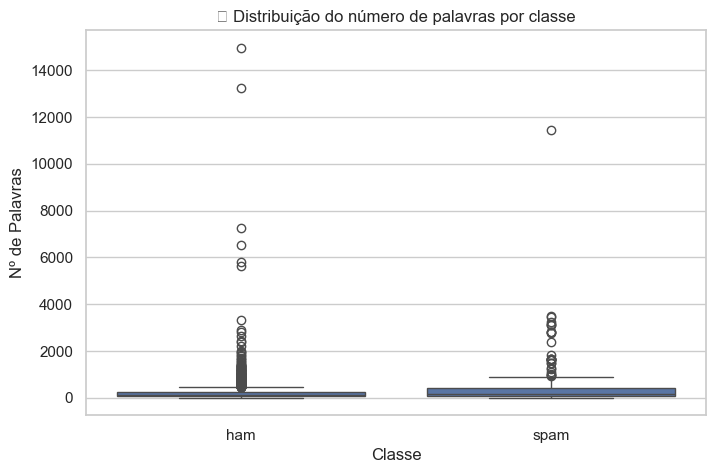

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


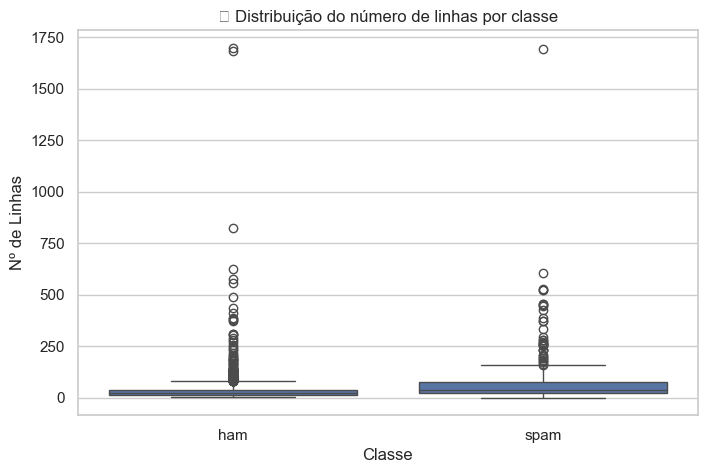

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


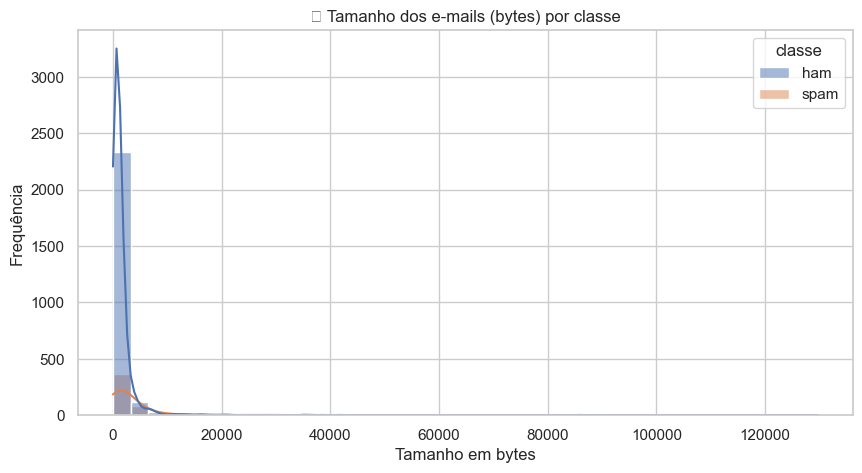

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128206 (\N{PAPERCLIP}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


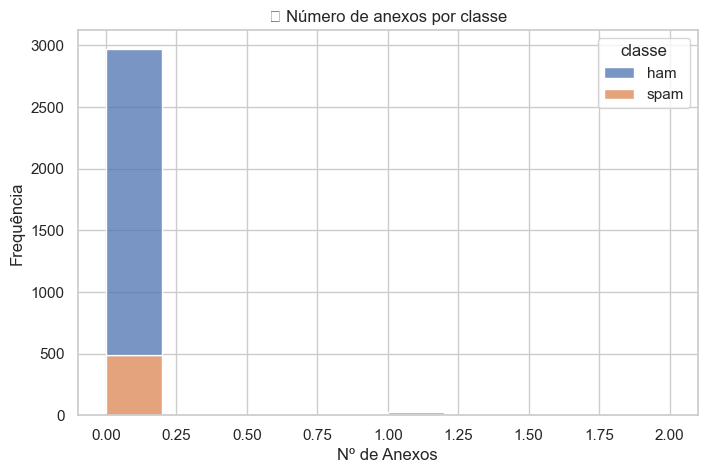

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


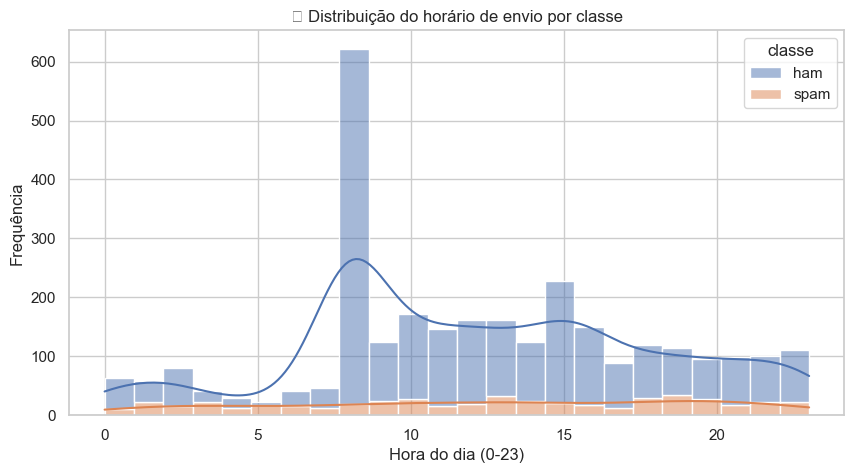

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


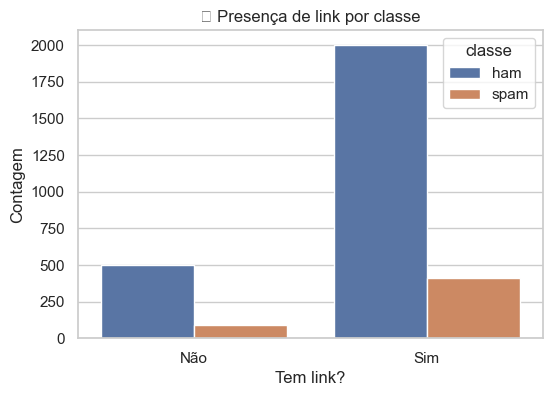

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


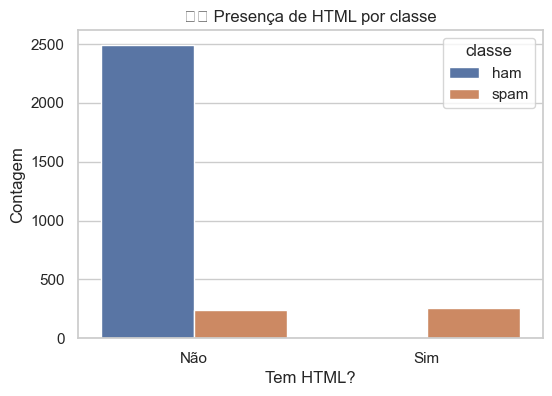

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128206 (\N{PAPERCLIP}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


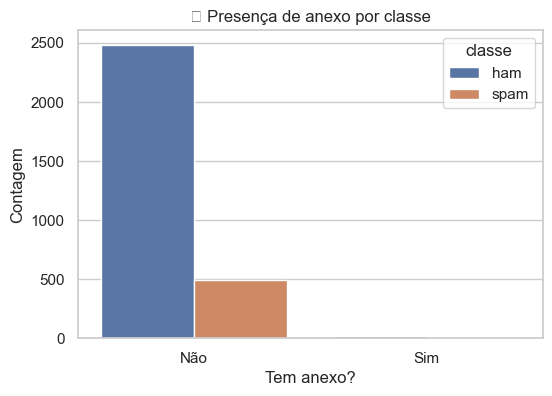

In [77]:
'''Features numericas'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#n_palavras por classs
plt.figure(figsize=(8, 5))
sns.boxplot(x="classe", y="n_palavras", data=df)
plt.title("📦 Distribuição do número de palavras por classe")
plt.xlabel("Classe")
plt.ylabel("Nº de Palavras")
plt.show()

#n_linhas por classs
plt.figure(figsize=(8, 5))
sns.boxplot(x="classe", y="n_linhas", data=df)
plt.title("📦 Distribuição do número de linhas por classe")
plt.xlabel("Classe")
plt.ylabel("Nº de Linhas")
plt.show()

#tamanho_bytes por classs
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="tamanho_bytes", hue="classe", bins=40, kde=True)
plt.title("📏 Tamanho dos e-mails (bytes) por classe")
plt.xlabel("Tamanho em bytes")
plt.ylabel("Frequência")
plt.show()

#num_anexos por classs
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x="num_anexos", hue="classe", multiple="stack", bins=10)
plt.title("📎 Número de anexos por classe")
plt.xlabel("Nº de Anexos")
plt.ylabel("Frequência")
plt.show()

#hora_envio por classs
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="hora_envio", hue="classe", bins=24, kde=True, multiple="stack")
plt.title("⏰ Distribuição do horário de envio por classe")
plt.xlabel("Hora do dia (0-23)")
plt.ylabel("Frequência")
plt.show()

#tem_link por classs
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="tem_link", hue="classe")
plt.title("🔗 Presença de link por classe")
plt.xlabel("Tem link?")
plt.ylabel("Contagem")
plt.xticks([0, 1], ["Não", "Sim"])
plt.show()

#tem_html por classs
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="tem_html", hue="classe")
plt.title("🖼️ Presença de HTML por classe")
plt.xlabel("Tem HTML?")
plt.ylabel("Contagem")
plt.xticks([0, 1], ["Não", "Sim"])
plt.show()

#tem_anexo por classs
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x="tem_arquivo_anexo", hue="classe")
plt.title("📎 Presença de anexo por classe")
plt.xlabel("Tem anexo?")
plt.ylabel("Contagem")
plt.xticks([0, 1], ["Não", "Sim"])
plt.show()




C:\Users\felip\AppData\Local\Temp\ipykernel_28508\873683587.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_remetentes.values, y=top_remetentes.index, palette="viridis")
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128228 (\N{OUTBOX TRAY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


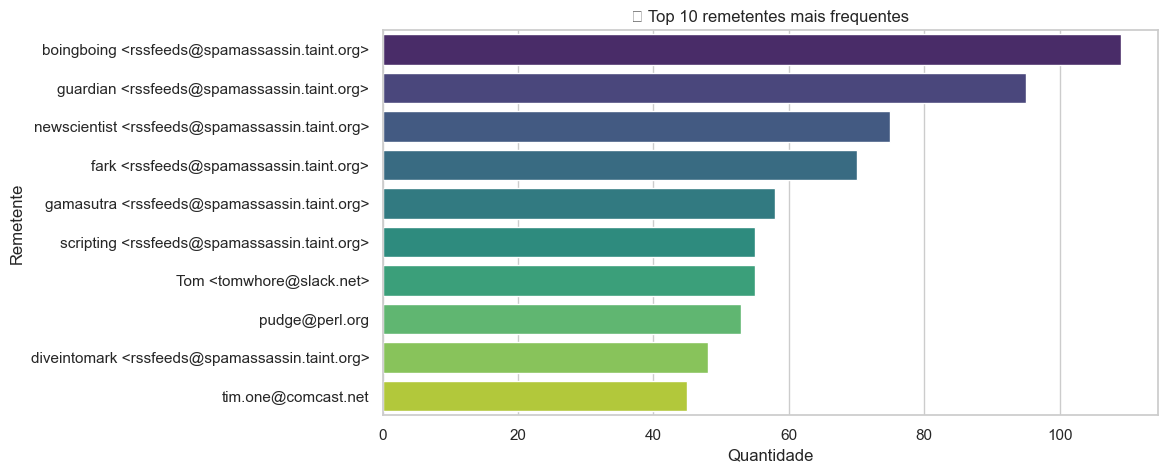

C:\Users\felip\AppData\Local\Temp\ipykernel_28508\873683587.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_destinatarios.values, y=top_destinatarios.index, palette="crest")
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128229 (\N{INBOX TRAY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


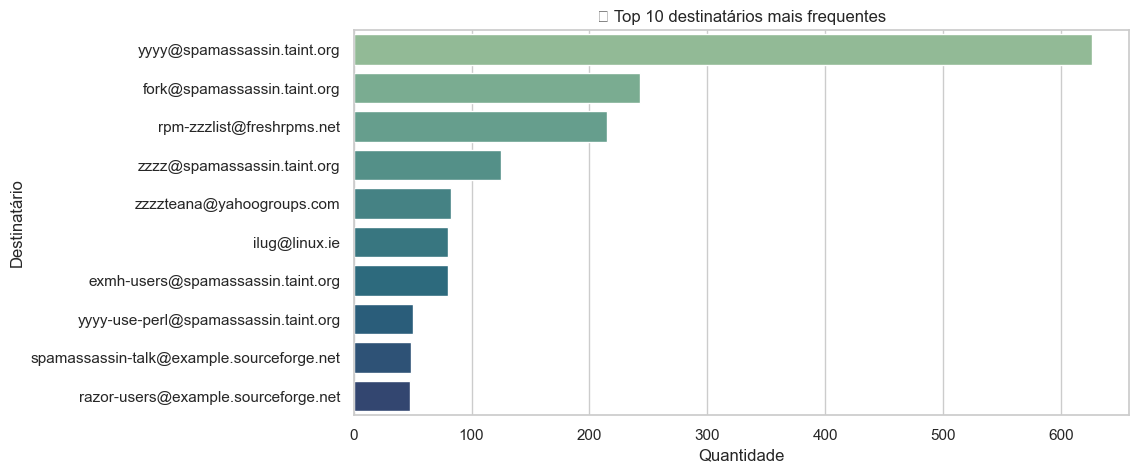

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


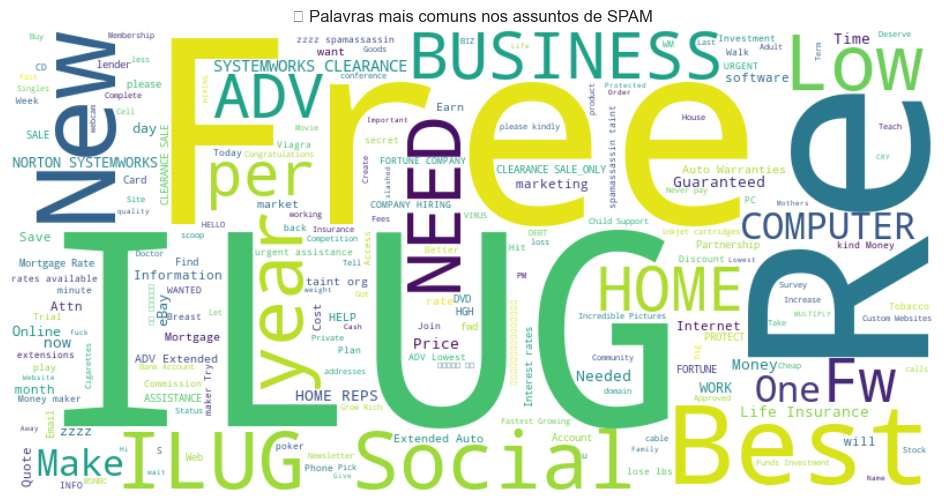

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


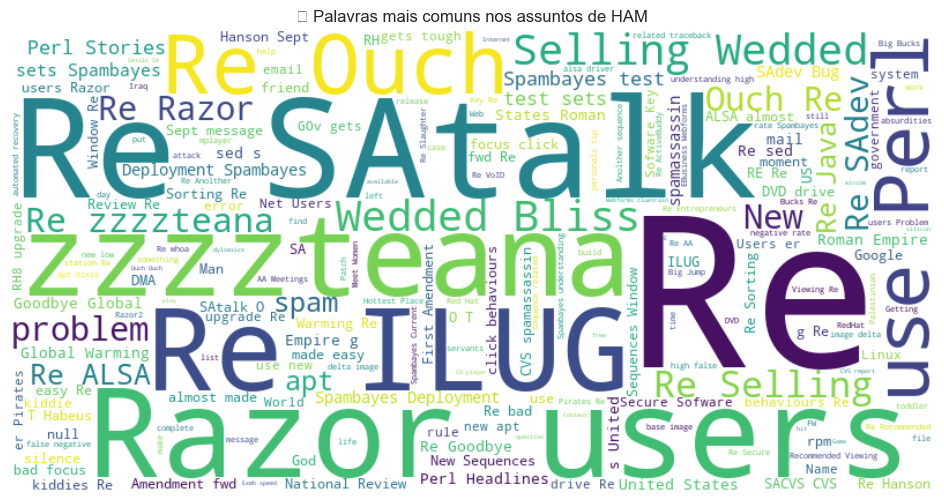

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


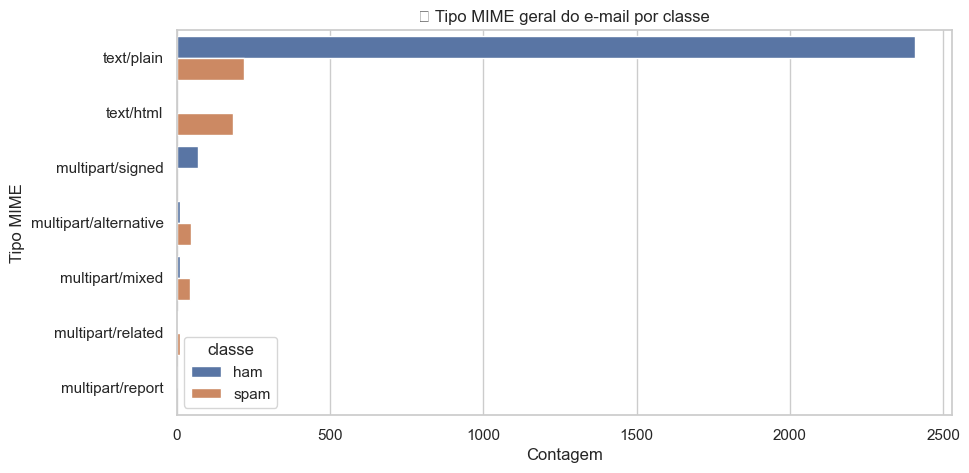

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128292 (\N{INPUT SYMBOL FOR LATIN LETTERS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


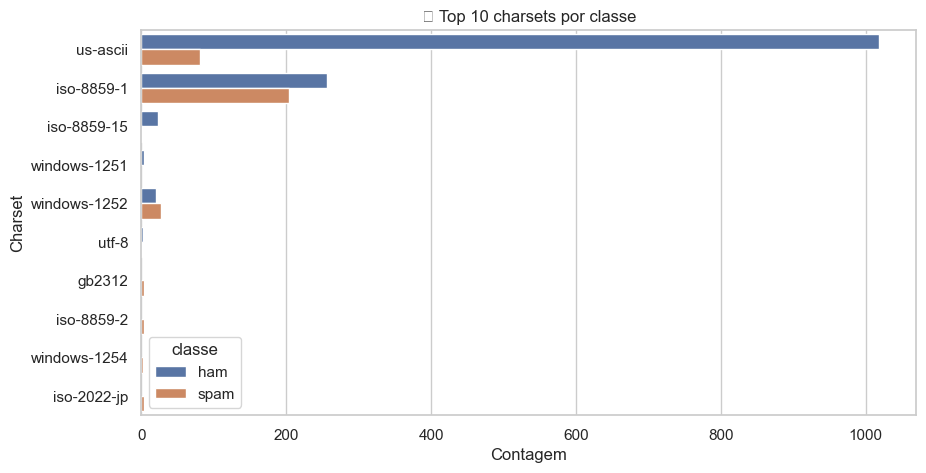

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


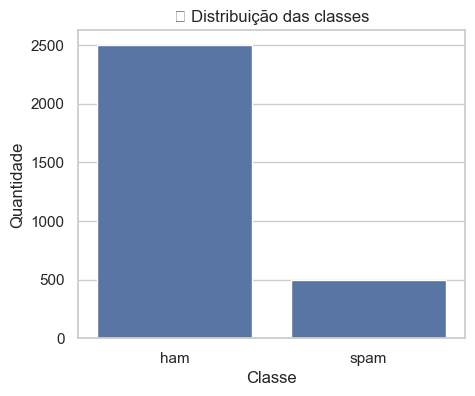

In [78]:
'''Features categóricas'''
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
from email.utils import parsedate_to_datetime
import numpy as np

sns.set(style="whitegrid")

#remetente mais frequente
top_remetentes = df["remetente"].value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_remetentes.values, y=top_remetentes.index, palette="viridis")
plt.title("📤 Top 10 remetentes mais frequentes")
plt.xlabel("Quantidade")
plt.ylabel("Remetente")
plt.show()

#destinatario mais frequente
top_destinatarios = df["destinatario"].dropna().value_counts().nlargest(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_destinatarios.values, y=top_destinatarios.index, palette="crest")
plt.title("📥 Top 10 destinatários mais frequentes")
plt.xlabel("Quantidade")
plt.ylabel("Destinatário")
plt.show()


#wordcloud de assuntos spamxham
# Assuntos spam
text_spam = " ".join(df[df["classe"] == "spam"]["assunto"].dropna().astype(str))
wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(text_spam)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.axis("off")
plt.title("🧾 Palavras mais comuns nos assuntos de SPAM")
plt.show()

# Assuntos ham
text_ham = " ".join(df[df["classe"] == "ham"]["assunto"].dropna().astype(str))
wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(text_ham)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.axis("off")
plt.title("🧾 Palavras mais comuns nos assuntos de HAM")
plt.show()

#tipo mime email
plt.figure(figsize=(10, 5))
sns.countplot(data=df, y="tipo_mime_email", hue="classe", order=df["tipo_mime_email"].value_counts().index)
plt.title("📦 Tipo MIME geral do e-mail por classe")
plt.xlabel("Contagem")
plt.ylabel("Tipo MIME")
plt.show()

#charset por classs
top_charsets = df["charset"].dropna().value_counts().nlargest(10).index

plt.figure(figsize=(10, 5))
sns.countplot(data=df[df["charset"].isin(top_charsets)], y="charset", hue="classe")
plt.title("🔤 Top 10 charsets por classe")
plt.xlabel("Contagem")
plt.ylabel("Charset")
plt.show()

#distribuição de classes
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x="classe")
plt.title("📊 Distribuição das classes")
plt.xlabel("Classe")
plt.ylabel("Quantidade")
plt.show()




In [79]:
'''Removendo outliers'''
df_limpo = df[df["n_palavras"] <= 3500]
df_limpo = df_limpo[df_limpo["n_linhas"] <= 600]
df_limpo = df_limpo[~df_limpo["remetente"].str.contains("rssfeeds@spamassassin.taint.org", na=False)]



print(f"E-mails removidos: {df.shape[0] - df_limpo.shape[0]}")
print(f'total de spam e ham: {df_limpo["classe"].value_counts()}')


E-mails removidos: 633
total de spam e ham: classe
ham     1871
spam     496
Name: count, dtype: int64


c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


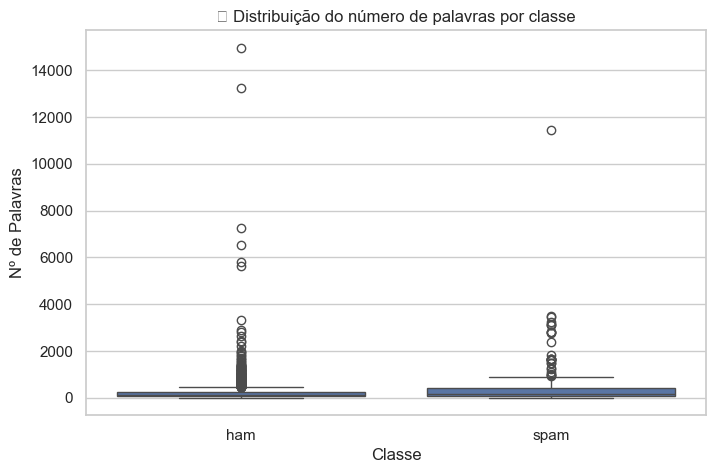

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


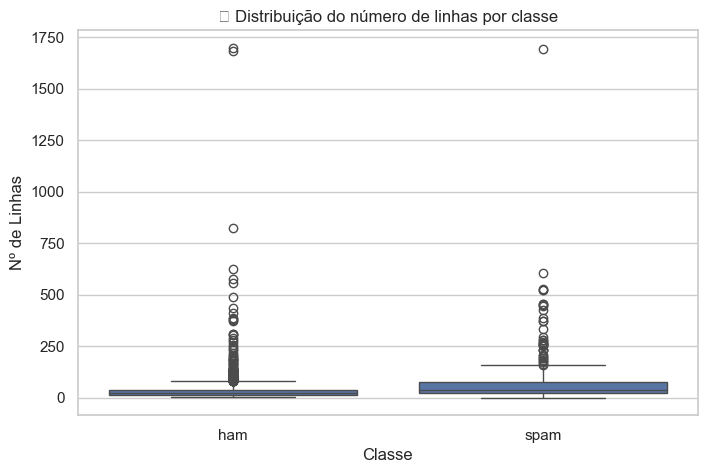

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9200 (\N{ALARM CLOCK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


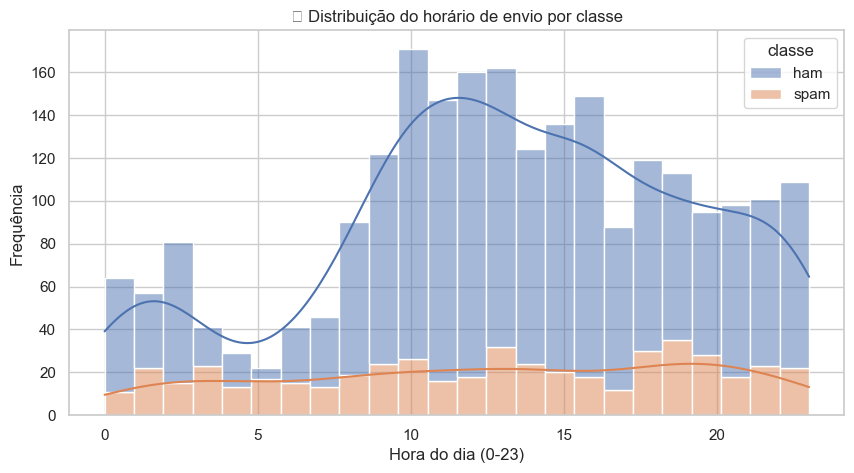

In [80]:
'''Graficos apos remocao de outliers'''
#n_palavras por classs
plt.figure(figsize=(8, 5))
sns.boxplot(x="classe", y="n_palavras", data=df)
plt.title("📦 Distribuição do número de palavras por classe")
plt.xlabel("Classe")
plt.ylabel("Nº de Palavras")
plt.show()

#n_linhas por classs
plt.figure(figsize=(8, 5))
sns.boxplot(x="classe", y="n_linhas", data=df)
plt.title("📦 Distribuição do número de linhas por classe")
plt.xlabel("Classe")
plt.ylabel("Nº de Linhas")
plt.show()

#hora_envio por classs
plt.figure(figsize=(10, 5))
sns.histplot(data=df_limpo, x="hora_envio", hue="classe", bins=24, kde=True, multiple="stack")
plt.title("⏰ Distribuição do horário de envio por classe")
plt.xlabel("Hora do dia (0-23)")
plt.ylabel("Frequência")
plt.show()

In [81]:
sanity_check(df_limpo)

,remetente,destinatario,assunto,data_envio,tipo_mime_email,tipo_mime_parte,charset,conteudo,n_palavras,n_linhas,tamanho_bytes,tem_link,tem_html,tem_arquivo_anexo,num_anexos,hora_envio,classe
0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,Re: New Sequences Window,"Thu, 22 Aug 2002 18:26:25 +0700",text/plain,text/plain,us-ascii,"Date: Wed, 21 Aug 2002 10:54:46 -05...",225,50,1604,True,False,False,0,18.0,ham
1,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",[zzzzteana] RE: Alexander,"Thu, 22 Aug 2002 12:46:18 +0100",text/plain,text/plain,us-ascii,"Martin A posted:\nTassos Papadopoulos, the Gre...",111,26,899,True,False,False,0,12.0,ham
2,Tim Chapman <timc@2ubh.com>,zzzzteana <zzzzteana@yahoogroups.com>,[zzzzteana] Moscow bomber,"Thu, 22 Aug 2002 13:52:38 +0100",text/plain,text/plain,us-ascii,Man Threatens Explosion In Moscow \n\nThursday...,252,38,1751,True,False,False,0,13.0,ham
3,Monty Solomon <monty@roscom.com>,undisclosed-recipient:;,[IRR] Klez: The Virus That Won't Die,"Thu, 22 Aug 2002 09:15:25 -0400",text/plain,text/plain,us-ascii,Klez: The Virus That Won't Die\n \nAlready the...,164,32,1127,True,False,False,0,9.0,ham
4,Stewart Smith <Stewart.Smith@ee.ed.ac.uk>,zzzzteana@yahoogroups.com,Re: [zzzzteana] Nothing like mama used to make,"Thu, 22 Aug 2002 14:38:22 +0100",text/plain,text/plain,us-ascii,"> in adding cream to spaghetti carbonara, whi...",143,31,1052,True,False,False,0,14.0,ham


<class 'pandas.core.frame.DataFrame'>
Index: 2367 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   remetente          2367 non-null   object 
 1   destinatario       2215 non-null   object 
 2   assunto            2367 non-null   object 
 3   data_envio         2367 non-null   object 
 4   tipo_mime_email    2367 non-null   object 
 5   tipo_mime_parte    2367 non-null   object 
 6   charset            1649 non-null   object 
 7   conteudo           2367 non-null   object 
 8   n_palavras         2367 non-null   int64  
 9   n_linhas           2367 non-null   int64  
 10  tamanho_bytes      2367 non-null   int64  
 11  tem_link           2367 non-null   bool   
 12  tem_html           2367 non-null   bool   
 13  tem_arquivo_anexo  2367 non-null   bool   
 14  num_anexos         2367 non-null   int64  
 15  hora_envio         2365 non-null   float64
 16  classe             2367 non-n

None

In [166]:
'''Separacao dos dados em treino e teste'''

from sklearn.model_selection import train_test_split

# 1. Verifica se há e-mails sem remetente
faltando_remetente = df_limpo["remetente"].isna().sum()
print(f"E-mails sem remetente: {faltando_remetente}")
assert faltando_remetente == 0, "Há e-mails sem remetente. Trate-os antes de continuar."

# 2. Coleta todos os remetentes únicos
remetentes_unicos = df_limpo["remetente"].unique()
print(f"Total de remetentes únicos: {len(remetentes_unicos)}")

# 3. Separa remetentes entre treino e teste
remetentes_treino, remetentes_teste = train_test_split(
    remetentes_unicos,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

# 4. Filtra os e-mails conforme os remetentes separados
df_treino = df_limpo[df_limpo["remetente"].isin(remetentes_treino)]
df_teste = df_limpo[df_limpo["remetente"].isin(remetentes_teste)]

# 5. Verifica se há algum remetente duplicado nos dois conjuntos
remetentes_intersecao = set(df_treino["remetente"]) & set(df_teste["remetente"])
print(f"Remetentes compartilhados entre treino e teste: {len(remetentes_intersecao)}")
assert len(remetentes_intersecao) == 0, "Remetente encontrado nos dois conjuntos!"

# 6. Exibe o resultado final
print(f"Conjunto de treino: {df_treino.shape[0]} e-mails")
print(f"Conjunto de teste:  {df_teste.shape[0]} e-mails")

x_train = df_treino.drop(columns=["classe"])
y_train = df_treino["classe"]

x_test = df_teste.drop(columns=["classe"])
y_test = df_teste["classe"]

E-mails sem remetente: 0
Total de remetentes únicos: 901
Remetentes compartilhados entre treino e teste: 0
Conjunto de treino: 1947 e-mails
Conjunto de teste:  420 e-mails


In [167]:
'''vendo um exemplo de email com html'''
df_html = df_treino[df_treino["tem_html"] == True]
print(df_html["conteudo"].iloc[8])

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

In [168]:
import re
from html import unescape
from sklearn.base import BaseEstimator, TransformerMixin
from email.message import Message

class EmailTextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, col="conteudo"):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X[self.col]
        return X.apply(self._processa_entrada)

    def _processa_entrada(self, entrada):
        # Caso seja um objeto de e-mail
        if isinstance(entrada, Message):
            return self.email_to_text(entrada)
        # Caso seja uma string com HTML
        elif isinstance(entrada, str):
            if "<html" in entrada.lower() or "<body" in entrada.lower():
                return self.html_to_plain_text(entrada)
            return entrada  # já é texto simples
        # Se não for reconhecido, retorna vazio
        return ""

    def html_to_plain_text(self, html):
        text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
        text = re.sub('<a\\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
        text = re.sub('<.*?>', '', text, flags=re.M | re.S)
        text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
        return unescape(text)

    def email_to_text(self, email):
        html = None
        for part in email.walk():
            ctype = part.get_content_type()
            if ctype not in ("text/plain", "text/html"):
                continue
            try:
                content = part.get_content()
            except:
                content = str(part.get_payload())
            if ctype == "text/plain":
                return content
            else:
                html = content
        if html:
            return self.html_to_plain_text(html)
        return ""


In [169]:
''''Testando o transformador'''
import numpy as np

print(df_html["conteudo"].iloc[8])

exemplo = df_html.iloc[[8]][["conteudo"]]  # DataFrame 1x1
limpo = EmailTextCleaner().fit_transform(exemplo)

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<HTML><HEAD>
<META content="text/html; charset=windows-1252" http-equiv=Content-Type>
<META content="MSHTML 5.00.2314.1000" name=GENERATOR></HEAD>
<BODY><!-- Inserted by Calypso -->
<TABLE border=0 cellPadding=0 cellSpacing=2 id=_CalyPrintHeader_ rules=none 
style="COLOR: black; DISPLAY: none" width="100%">
  <TBODY>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TD></TR>
  <TR>
    <TD colSpan=3>
      <HR color=black noShade SIZE=1>
    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso --><FONT 
color=#000000 face=VERDANA,ARIAL,HELVETICA size=-2><BR></FONT></TD></TR></TABLE><!-- End Calypso --><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=#ff0000 
face="Copperplate Gothic Bold" size=5 PTSIZE="10">
<CENTER>Why Spend More Than You Have To?
<CENTER><FONT color=#ff0000 face="Copp

In [170]:
print(limpo.iloc[0])


Save up to 70% on Life Insurance.
Why Spend More Than You Have To?
Life Quote Savings
    Ensuring your
      family's financial security is very important. Life Quote Savings makes
      buying life insurance simple and affordable. We Provide FREE Access to The
      Very Best Companies and The Lowest Rates.
          Life Quote Savings is FAST, EASY and
            SAVES you money! Let us help you get started with the best values in
            the country on new coverage. You can SAVE hundreds or even thousands
            of dollars by requesting a FREE quote from Lifequote Savings. Our
            service will take you less than 5 minutes to complete. Shop and
            compare. SAVE up to 70% on all types of Life insurance!
             HYPERLINK Click Here For Your
            Free Quote!
          Protecting your family is the best investment you'll ever
          make!
      If you are in receipt of this email
      in error and/or wish to be removed from our list,  HYPERLI

In [171]:
'''Segundo transformador COUNTER'''
import re
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=False):
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for texto in X:
            text = texto or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                text = re.sub(r"http\S+|www\.\S+", " URL ", text)
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', ' NUMBER ', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text)
            word_counts = Counter(text.split())

            # Se quiser usar stemming depois, adicione aqui
            X_transformed.append(word_counts)
        return np.array(X_transformed)


In [172]:
''''Testando o transformador COUNTER'''
# Pegando um e-mail qualquer do df_treino
exemplo = df_treino.iloc[[8]][["conteudo"]]  # DataFrame com 1 linha

# Aplicando o transformador de contagem de palavras
word_counter_transformer = EmailToWordCounterTransformer()
resultado = word_counter_transformer.fit_transform(exemplo["conteudo"])

exemplo.head(1)
print(exemplo["conteudo"].iloc[0])

Yes - great minds think alike. But even withput eval rules it would be very 
useful. It would allow us to respond quickly to spammer's tricks.

Theo Van Dinter wrote:
> On Thu, Aug 22, 2002 at 07:27:52AM -0700, Marc Perkel wrote:
> 
>>Has anyone though of the idea of live updates of rules after release? The 
>>idea being that the user can run a cron job once a week or so and get the 
>>new default rule set. This would allow us to react faster to:
> 
> 
> I suggested this a few months ago.  I don't remember the details of what
> came out of it except that it would only be useful for non-eval rules
> since those require code changes.
> 



-------------------------------------------------------
This sf.net email is sponsored by: OSDN - Tired of that same old
cell phone?  Get a new here for FREE!
https://www.inphonic.com/r.asp?r=sourceforge1&refcode1=vs3390
_______________________________________________
Spamassassin-devel mailing list
Spamassassin-devel@lists.sourceforge.net
https://list

In [173]:
resultado[0]

Counter({'NUMBER': 6,
         'of': 6,
         'the': 5,
         'it': 4,
         'would': 4,
         'to': 4,
         'a': 4,
         'rules': 3,
         'that': 3,
         'this': 3,
         'eval': 2,
         'be': 2,
         'useful': 2,
         'allow': 2,
         'us': 2,
         'wrote': 2,
         'idea': 2,
         'get': 2,
         'new': 2,
         'i': 2,
         'for': 2,
         'net': 2,
         'URL': 2,
         'spamassassin': 2,
         'devel': 2,
         'yes': 1,
         'great': 1,
         'minds': 1,
         'think': 1,
         'alike': 1,
         'but': 1,
         'even': 1,
         'withput': 1,
         'very': 1,
         'respond': 1,
         'quickly': 1,
         'spammer': 1,
         's': 1,
         'tricks': 1,
         'theo': 1,
         'van': 1,
         'dinter': 1,
         'on': 1,
         'thu': 1,
         'aug': 1,
         'at': 1,
         'am': 1,
         'marc': 1,
         'perkel': 1,
         'has': 1

In [174]:
'''Transformador counter to vetor'''
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size

    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)  # Limita contagens exageradas
        most_common = total_count.most_common(self.vocabulary_size)
        self.vocabulary_ = {word: idx + 1 for idx, (word, _) in enumerate(most_common)}
        return self

    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                col_idx = self.vocabulary_.get(word, 0)  # índice 0 = fora do vocabulário
                rows.append(row)
                cols.append(col_idx)
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))


In [175]:
'''Testando o transformador COUNTER TO VETOR'''
# 1. Pegando um e-mail do df_treino
exemplo = df_treino.iloc[[8]][["conteudo"]]  # 1 linha do DataFrame

# 2. Aplicando o primeiro transformador para gerar um Counter
word_counter_transformer = EmailToWordCounterTransformer()
counter = word_counter_transformer.fit_transform(exemplo["conteudo"])

# 3. Treinando o segundo transformador com o próprio counter (exemplo de teste individual)
vector_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_vetor = vector_transformer.fit_transform(counter)

# 4. Mostrando o vetor resultante (forma densa para visualizar melhor)
print(X_vetor.toarray())


[[114   6   6   5   4   4   4   4   3   3   3]]


In [176]:
'''Construcao de modelos'''
def get_columns_names():
    text_col = "conteudo"

    numerical_cols = [
        "n_palavras", "n_linhas", "tamanho_bytes",
        "num_anexos", "hora_envio"
    ]

    boolean_cols = [
        "tem_link", "tem_html", "tem_arquivo_anexo"
    ]

    categorical_cols = [
        "remetente", "destinatario", "assunto", "data_envio",
        "tipo_mime_email", "tipo_mime_parte", "charset"
    ]

    return text_col, numerical_cols, categorical_cols, boolean_cols


In [177]:
'''Modelo trivial'''
from sklearn.base import BaseEstimator


class NeverSpamClassifier(BaseEstimator):

    def fit(self, X, y=None):
        # Nada a ser feito no treinamento.
        pass

    def predict(self, X):
        # Recebe len(X) amostras, chuta "ham" como resposta para todas!
        return ['ham'] * len(X)

def create_modelo_trivial():
    return NeverSpamClassifier()

In [178]:
'''Logistic regression'''
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)


def create_simple_model():
    text_col, numerical_cols, categorical_cols, boolean_cols = get_columns_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean'))
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ])

    preprocessing = ColumnTransformer(
        transformers = [
            ('numerical', numerical_pipeline, numerical_cols),
            ('categorical', categorical_pipeline, categorical_cols),
        ],
        remainder='passthrough'
    )

    model = LogisticRegression()

    simple_model = Pipeline([
        ('drop_text', ColumnDropper(columns_to_drop=["conteudo"])),
        ('preprocessing', preprocessing),
        ('model', model)
    ])

    return simple_model

In [181]:
'''Histogram gradient boosting classifier'''
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import FunctionTransformer

def create_complex_model():
    text_col, numerical_cols, categorical_cols, boolean_cols = get_columns_names()

    text_pipeline = Pipeline([
        ('cleaner', EmailTextCleaner()),
        ('counter', EmailToWordCounterTransformer()),
        ('vectorizer', WordCounterToVectorTransformer(vocabulary_size=1000)),
    ])

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)),
    ])

    boolean_pipeline = Pipeline([
    ("to_int", FunctionTransformer(lambda x: x.astype(int)))
    ])

    preprocessing = ColumnTransformer(
        transformers=[
            ('text', text_pipeline, [text_col]),
            ('numerical', numerical_pipeline, numerical_cols),
            ('categorical', categorical_pipeline, categorical_cols),
            ('boolean', boolean_pipeline, boolean_cols),
        ],
        remainder='passthrough'
    )

    model = HistGradientBoostingClassifier()

    complex_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model)
    ])

    return complex_model

In [182]:
'''Criando modelos'''

modelo_trivial = create_modelo_trivial()
modelo_simples = create_simple_model()
modelo_complexo = create_complex_model()

models = {
    'trivial': {
        'model' : modelo_trivial
    },
    'simples': {
        'model' : modelo_simples
    },
    'complexo': {
        'model' : modelo_complexo
    }
}

In [183]:
'''escolha de modelos'''
from sklearn.model_selection import cross_val_score
import time

for model_name, model_item in models.items():
    model = model_item['model']
    start_time = time.time()
    score = cross_val_score(
        model,
        x_train,
        y_train,
        cv=4,
        scoring='accuracy',
        n_jobs=-1,
    )
    elapsed_time = time.time() - start_time
    print(f'modelo {model_name} \n- tempo: {elapsed_time:.2f} segundos \n- acuracia: {score.mean():.4f}')
    print(score)
    print('\n ')


modelo trivial 
- tempo: 4.95 segundos 
- acuracia: 0.7948
[1.         1.         1.         0.17901235]

 
modelo simples 
- tempo: 5.45 segundos 
- acuracia: 0.8983
[0.87474333 0.92402464 0.87268994 0.9218107 ]

 
modelo complexo 
- tempo: 59.86 segundos 
- acuracia: 0.9820
[0.98151951 0.9835729  0.98151951 0.98148148]

 


In [184]:
# '''Criando param grid'''

# # param_grid_simple = {
# #     'preprocessing__numerical__imputer__strategy': ['mean', 'median'],
# #     'model__max_iter': [200, 500],
# # }

# param_grid_complex = {
#     'preprocessing__numerical__imputer__strategy': ['mean', 'median'],
#     'preprocessing__numerical__poly__degree': [1, 2],
#     'model__max_depth': [5],
#     'model__max_iter': [100],
# }

# params = {
#     # 'simple': param_grid_simple,
#     'complex': param_grid_complex,
# }

# models_param_grid = {
#     # 'simple': {
#     #     'model' : modelo_simples,
#     # },
#     'complex': {
#         'model' : modelo_complexo,
#     }
# }

In [185]:
# from sklearn.model_selection import GridSearchCV
# CV = 3
# for model_name, model_item in models_param_grid.items():
#     model = model_item['model']
#     param_grid = params[model_name]

#     model_item['grid_search'] = GridSearchCV(
#         model,
#         param_grid,
#         cv=CV,
#         scoring='accuracy',
#         n_jobs=-1,
#         return_train_score=True,
#     )

In [186]:
# for model_name, model_item in models_param_grid.items():
#     grid_search = model_item['grid_search']
#     grid_search.fit(x_train, y_train)

In [187]:
# for model_name, model_item in models_param_grid.items():
#     grid_search = model_item['grid_search']

#     print(f'{model_name} model:')
#     print(f'  - Hyperparameters search: {grid_search.param_grid}')
#     print()
#     print(f'  - Best hyperparameters: {grid_search.best_params_}')
#     print(f'  - Best Accuracy score: {-grid_search.best_score_:.2f}')
#     print()

#     df_results = pd.DataFrame(grid_search.cv_results_)
#     df_results = df_results.sort_values(by='rank_test_score')
#     display(-df_results[['mean_train_score', 'mean_test_score']].iloc[1, :].round(3))

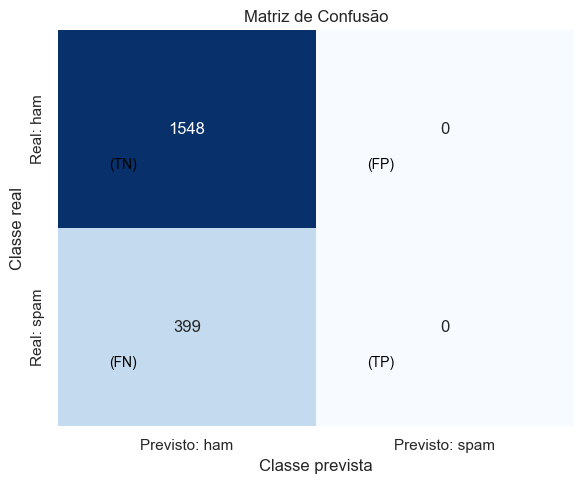

In [199]:
'''Matriz NeverSpam'''
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred_trivial = cross_val_predict(models['trivial']['model'], x_train, y_train, cv=4, n_jobs=-1)
mat_trivial = confusion_matrix(y_train, y_train_pred_trivial)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(mat_trivial, annot=True, fmt="d", cmap="Blues", cbar=False,
                 xticklabels=["Previsto: ham", "Previsto: spam"],
                 yticklabels=["Real: ham", "Real: spam"])
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Classe prevista")
ax.set_ylabel("Classe real")

# Adicionar labels (TN, FP, FN, TP)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
for i in range(2):
    for j in range(2):
        ax.text(j + 0.2, i + 0.7, f"({labels[i, j]})", color='black', fontsize=10)

plt.tight_layout()
plt.show()

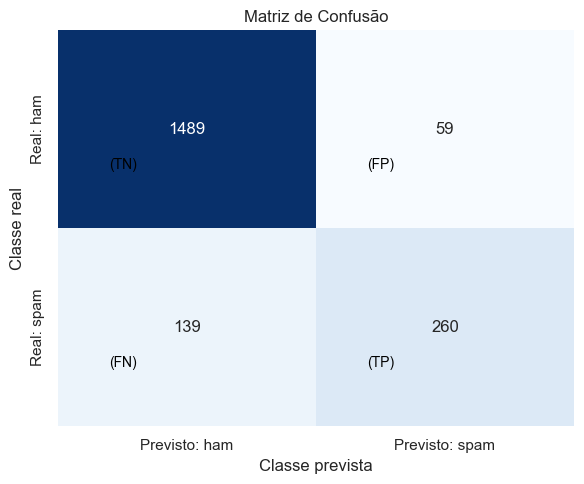

In [200]:
'''Matriz de confusao simple model'''
y_train_pred_simple = cross_val_predict(models['simples']['model'], x_train, y_train, cv=4, n_jobs=-1)
mat_simple = confusion_matrix(y_train, y_train_pred_simple)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(mat_simple, annot=True, fmt="d", cmap="Blues", cbar=False,
                 xticklabels=["Previsto: ham", "Previsto: spam"],
                 yticklabels=["Real: ham", "Real: spam"])
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Classe prevista")
ax.set_ylabel("Classe real")

# Adicionar labels (TN, FP, FN, TP)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
for i in range(2):
    for j in range(2):
        ax.text(j + 0.2, i + 0.7, f"({labels[i, j]})", color='black', fontsize=10)

plt.tight_layout()
plt.show()

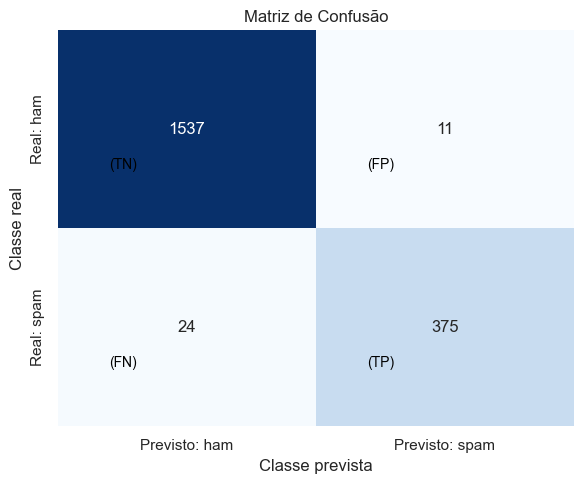

In [201]:
'''Matriz de confusao complex model'''
y_train_pred_complex = cross_val_predict(models['complexo']['model'], x_train, y_train, cv=4, n_jobs=-1)
mat_complex = confusion_matrix(y_train, y_train_pred_complex)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(mat_complex, annot=True, fmt="d", cmap="Blues", cbar=False,
                 xticklabels=["Previsto: ham", "Previsto: spam"],
                 yticklabels=["Real: ham", "Real: spam"])
ax.set_title("Matriz de Confusão")
ax.set_xlabel("Classe prevista")
ax.set_ylabel("Classe real")

# Adicionar labels (TN, FP, FN, TP)
labels = np.array([["TN", "FP"], ["FN", "TP"]])
for i in range(2):
    for j in range(2):
        ax.text(j + 0.2, i + 0.7, f"({labels[i, j]})", color='black', fontsize=10)

plt.tight_layout()
plt.show()

In [204]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

y_pred_models = [y_train_pred_trivial, y_train_pred_simple, y_train_pred_complex]

models['trivial']['y_pred'] = y_train_pred_trivial
models['simples']['y_pred'] = y_train_pred_simple
models['complexo']['y_pred'] = y_train_pred_complex

for model_name, model_item in models.items():
    y_pred = model_item['y_pred']
    precision = precision_score(y_train, y_pred, pos_label='spam')
    recall = recall_score(y_train, y_pred, pos_label='spam')
    f1 = f1_score(y_train, y_pred, pos_label='spam')
    print(f'{model_name} model:')
    print(f'  - Precision: {precision:.2f}')
    print(f'  - Recall: {recall:.2f}')
    print(f'  - F1 Score: {f1:.2f}')
    print()


trivial model:
  - Precision: 0.00
  - Recall: 0.00
  - F1 Score: 0.00

simples model:
  - Precision: 0.82
  - Recall: 0.65
  - F1 Score: 0.72

complexo model:
  - Precision: 0.97
  - Recall: 0.94
  - F1 Score: 0.96



c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


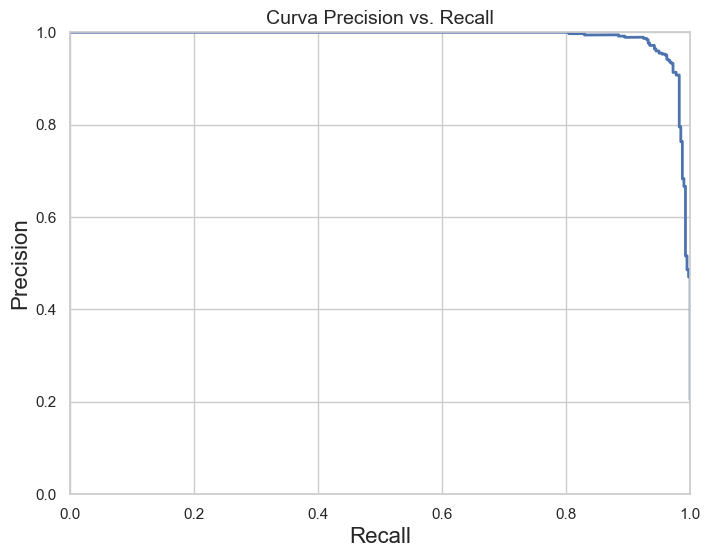

In [206]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Pegando as probabilidades da classe 'spam'
y_scores = cross_val_predict(
    models['complexo']['model'],
    x_train,
    y_train,
    cv=4,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Gera a curva
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores, pos_label='spam')

# Plota
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.title("Curva Precision vs. Recall", fontsize=14)
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.show()


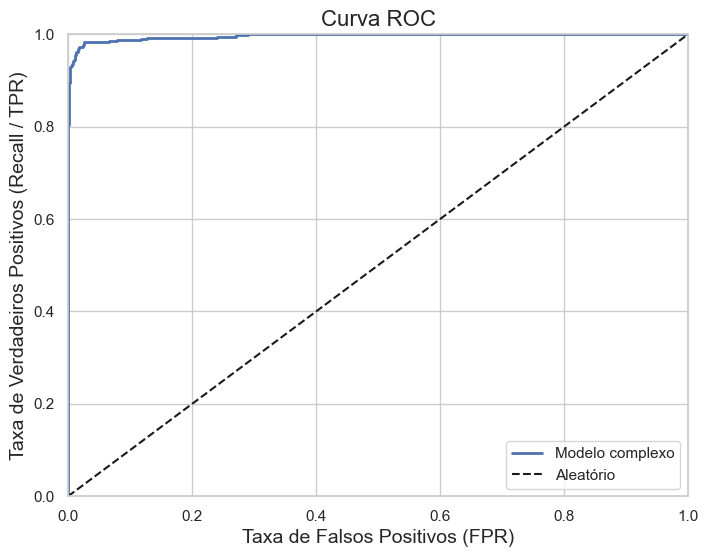

In [207]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Probabilidade da classe 'spam'
y_scores = cross_val_predict(
    models['complexo']['model'],
    x_train,
    y_train,
    cv=4,
    method='predict_proba',
    n_jobs=-1
)[:, 1]

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_train, y_scores, pos_label='spam')

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label='Modelo complexo')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Taxa de Verdadeiros Positivos (Recall / TPR)', fontsize=14)
plt.title('Curva ROC', fontsize=16)
plt.legend()
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.show()

In [208]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train, y_scores))

0.9960916503144165


In [209]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# 1. Treinar modelo
model = models["complexo"]["model"]
model.fit(x_train, y_train)

# 2. Fazer previsões
y_test_pred = model.predict(x_test)
y_test_proba = model.predict_proba(x_test)[:, 1]  # Para ROC AUC

# 3. Avaliar
print("Métricas no conjunto de teste:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_test_proba) :.3f}")

c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Métricas no conjunto de teste:
Accuracy:  0.993
Precision: 0.990
Recall:    0.979
F1 Score:  0.984
ROC AUC:   1.000


In [210]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

# 1. Treinar modelo
model = models["simples"]["model"]
model.fit(x_train, y_train)

# 2. Fazer previsões
y_test_pred = model.predict(x_test)
y_test_proba = model.predict_proba(x_test)[:, 1]  # Para ROC AUC

# 3. Avaliar
print("Métricas no conjunto de teste:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"Recall:    {recall_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_test_pred, pos_label='spam'):.3f}")
print(f"ROC AUC:   {roc_auc_score(y_test, y_test_proba) :.3f}")

Métricas no conjunto de teste:
Accuracy:  0.917
Precision: 0.970
Recall:    0.660
F1 Score:  0.785
ROC AUC:   0.933


c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\felip\OneDrive\Documentos\4_semestre\hands_on_machine_learning\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarnin